<a href="https://colab.research.google.com/github/servetgulnaroglu/Forecasting/blob/task7/notebooks/n7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <font color='#475468'> Bundling Recommendations:</font>
### <font color='#475468'> Can you bundle items that go together based on historical transactions?</font>

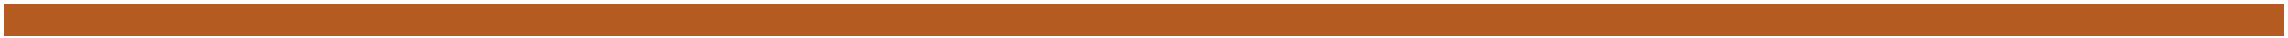

## Initialize

In [10]:
import pandas as pd

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Load Data

Remember the retail transactions data set that we used for customer segmentation...

In [11]:
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
dfRet = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/black-friday-sales-data.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
dfRet.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


WHITEBOARD >>

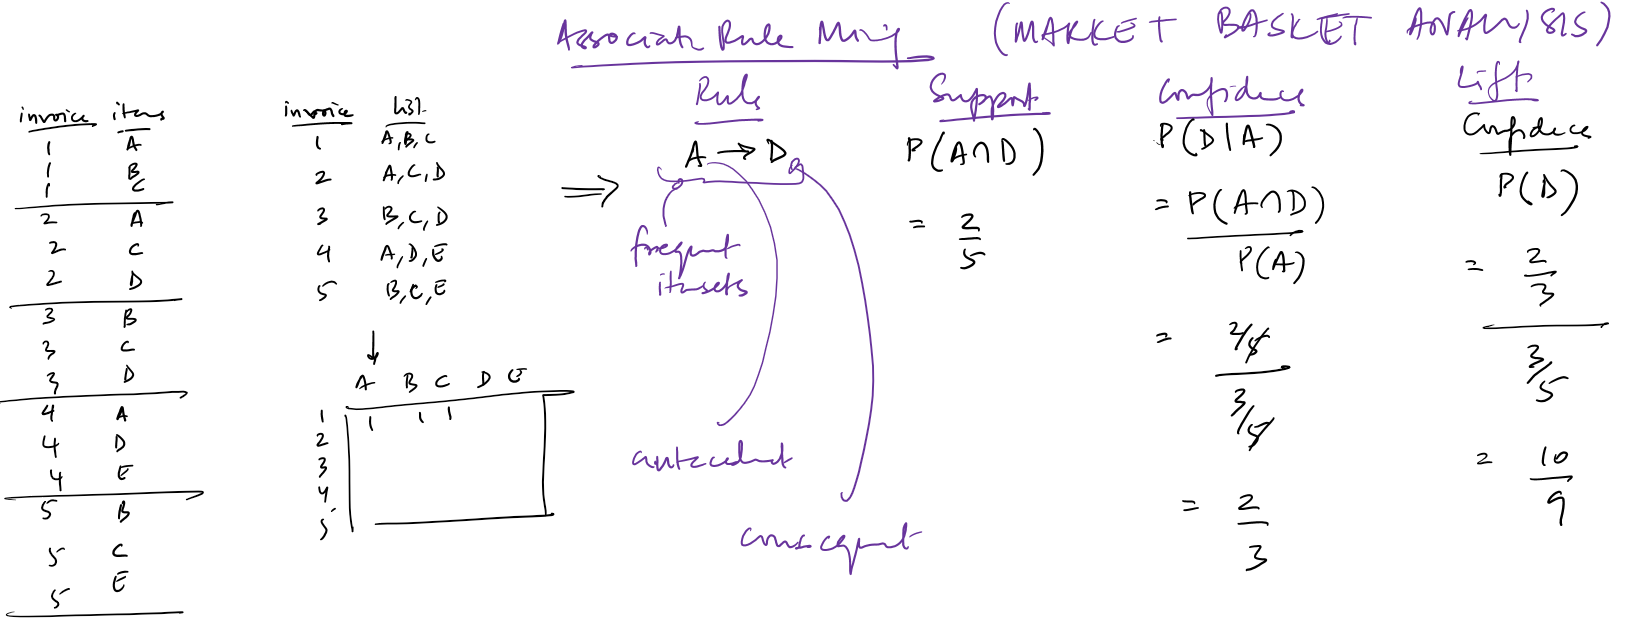

<< WHITEBOARD

Support = how likely is it for both items to show up together
Confidence = how likely is it for D to show up given A showed up
Lift = Confidence compared to D showing up anyway

## Prepare Data

In order to extract relationships between items, the data is first rearranged into a binary table where each transaction is a row, each column is an item, and the values are set to 1 if the item was part of the transaction.

In [14]:
dfRet['Purchase_ID'] = dfRet.groupby('User_ID').ngroup().astype(str)

# Display the result
dfRet.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,Purchase_ID
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370,0
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200,0
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422,0
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057,0
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969,1


In [15]:
# Drop missing values
dfRet.dropna(inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
# Convert to list format by grouping based on User_ID and aggregating Product_IDs
dfRetList = dfRet.groupby('Purchase_ID')['Product_ID'].apply(list)
dfRetList.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Purchase_ID
0       [P00248942, P00085942, P00102642, P00110842, P...
1       [P00289342, P00034742, P00177442, P00116842, P...
10      [P00110842, P00216342, P00116842, P00119742, P...
100     [P00071242, P00050442, P0097342, P00165442, P0...
1000    [P00148642, P00086042, P00102342, P00087042, P...
Name: Product_ID, dtype: object

Suppose we know what's already in the shopping cart, let's see if we can predict other items that the shopper may add.  This type of analysis is known as **Association Rule Mining** also commonly known as **Market Basket Analysis**.

## Build Model

### Association Rule Mining

Suppose we are interested in the relationship A -> B.  Then:

* **Support**: Fraction of transactions that contain both A and B = Freq(A,B)

* **Confidence**: How often B appears given A appeared = Support / Freq(A)

* **Lift**: Confidence given B appeared = Confidence / Freq(B)

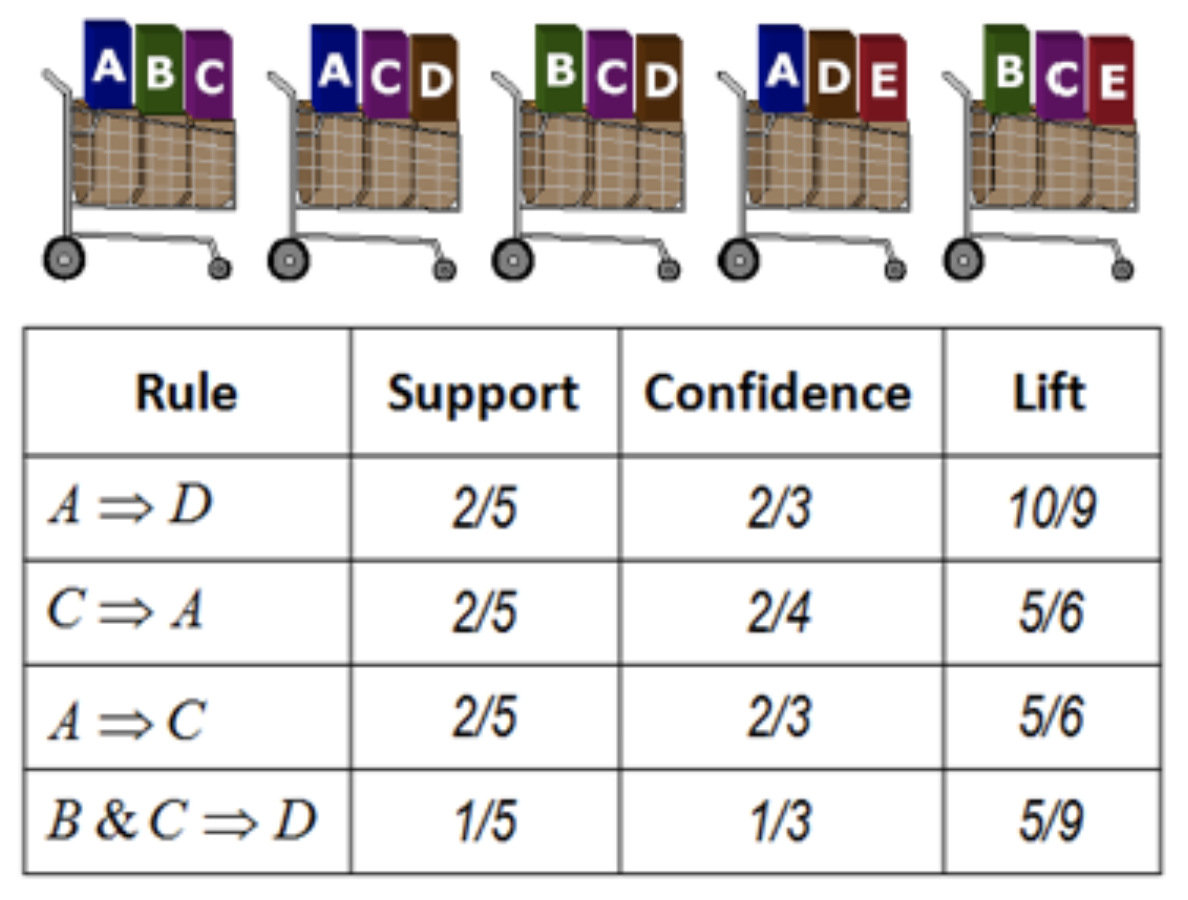

In [17]:
# Encode data as transaction matrix
from mlxtend.preprocessing import TransactionEncoder

mdlRetTe = TransactionEncoder()
mdlRetTe_array = mdlRetTe.fit(dfRetList).transform(dfRetList)
dfRtb = pd.DataFrame(mdlRetTe_array, columns=mdlRetTe.columns_)
dfRtb

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,P00000142,P00000242,P00000642,P00001042,P00001142,P00001542,P00002142,P00002242,P00003442,P00004242,...,P0096442,P0096542,P0096642,P0096742,P0096842,P0097342,P0099042,P0099742,P0099842,P0099942
0,True,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,True,True,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5865,False,False,False,False,False,True,True,False,False,False,...,False,False,False,False,False,True,False,False,False,False
5866,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
5867,False,True,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
5868,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [9]:
%%time
# Determine the items and itemsets with at least 1% support (generates all itemsets and then filters by support)

from mlxtend.frequent_patterns import apriori

frequent_itemsets = apriori(dfRtb, min_support=0.01, use_colnames=True)
frequent_itemsets

NameError: name 'dfRtb' is not defined

In [1]:
!pip3 install mlxtend --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 8.4 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.22.0
    Uninstalling mlxtend-0.22.0:
      Successfully uninstalled mlxtend-0.22.0


In [18]:
%%time
# Speed up by using pattern fragment growth method for mining frequent itemsets (uses density to find good itemsets)

from mlxtend.frequent_patterns import fpgrowth

frequent_itemsets = fpgrowth(dfRtb, min_support=0.01, use_colnames=True)
frequent_itemsets

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 2min 7s, sys: 575 ms, total: 2min 8s
Wall time: 2min 9s


,support,itemsets
0,0.275128,(P00025442)
1,0.245315,(P00184942)
2,0.239523,(P00059442)
3,0.218228,(P00110842)
4,0.212266,(P00102642)
...,...,...
206858,0.010562,"(P00059442, P00207342)"
206859,0.010221,"(P00080342, P00207342)"
206860,0.010051,"(P00105142, P00207342)"
206861,0.011073,"(P00001142, P00207342)"


In [19]:
# Evaluate the metrics, and filter the items and itemsets that have at least 70% confidence

from mlxtend.frequent_patterns import association_rules

a_rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
a_rules.sort_values(by=['confidence'],ascending=False,inplace=True)
a_rules.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
100,"(P00073842, P00243942, P00122442)",(P00057642),0.014140,0.250426,0.010733,0.759036,3.030981,0.007192,3.110733,0.679684
68,"(P00277642, P00129342, P00000142)",(P00145042),0.013969,0.239523,0.010562,0.756098,3.156680,0.007216,3.117956,0.692891
48,"(P00155442, P00209742)",(P00112542),0.016525,0.192675,0.012436,0.752577,3.905949,0.009252,3.262940,0.756481
101,"(P00032042, P00222942)",(P00145042),0.014991,0.239523,0.011244,0.750000,3.131223,0.007653,3.041908,0.690995
46,"(P00245642, P00112142, P00144642)",(P00110742),0.013629,0.274617,0.010221,0.750000,2.731079,0.006479,2.901533,0.642602


So, from the first row we see that if someone purchases PINK_REGENCY_TEACUP_AND_SAUCER, REGENCY_CAKESTAND_3_TIER, and ROSES_REGENCY_TEACUP_AND_SAUCER, then they would also purchase GREEN_REGENCY_TEACUP_AND_SAUCER with 89% confidence.

utexas_ds_orie_divider_gray.png

## Takeaways

* Introduced association rule mining to recommend item bundles using *Market Basket Analysis*
* Evaluated item bundles using *Support*, *Confidence*, and *Lift* metrics

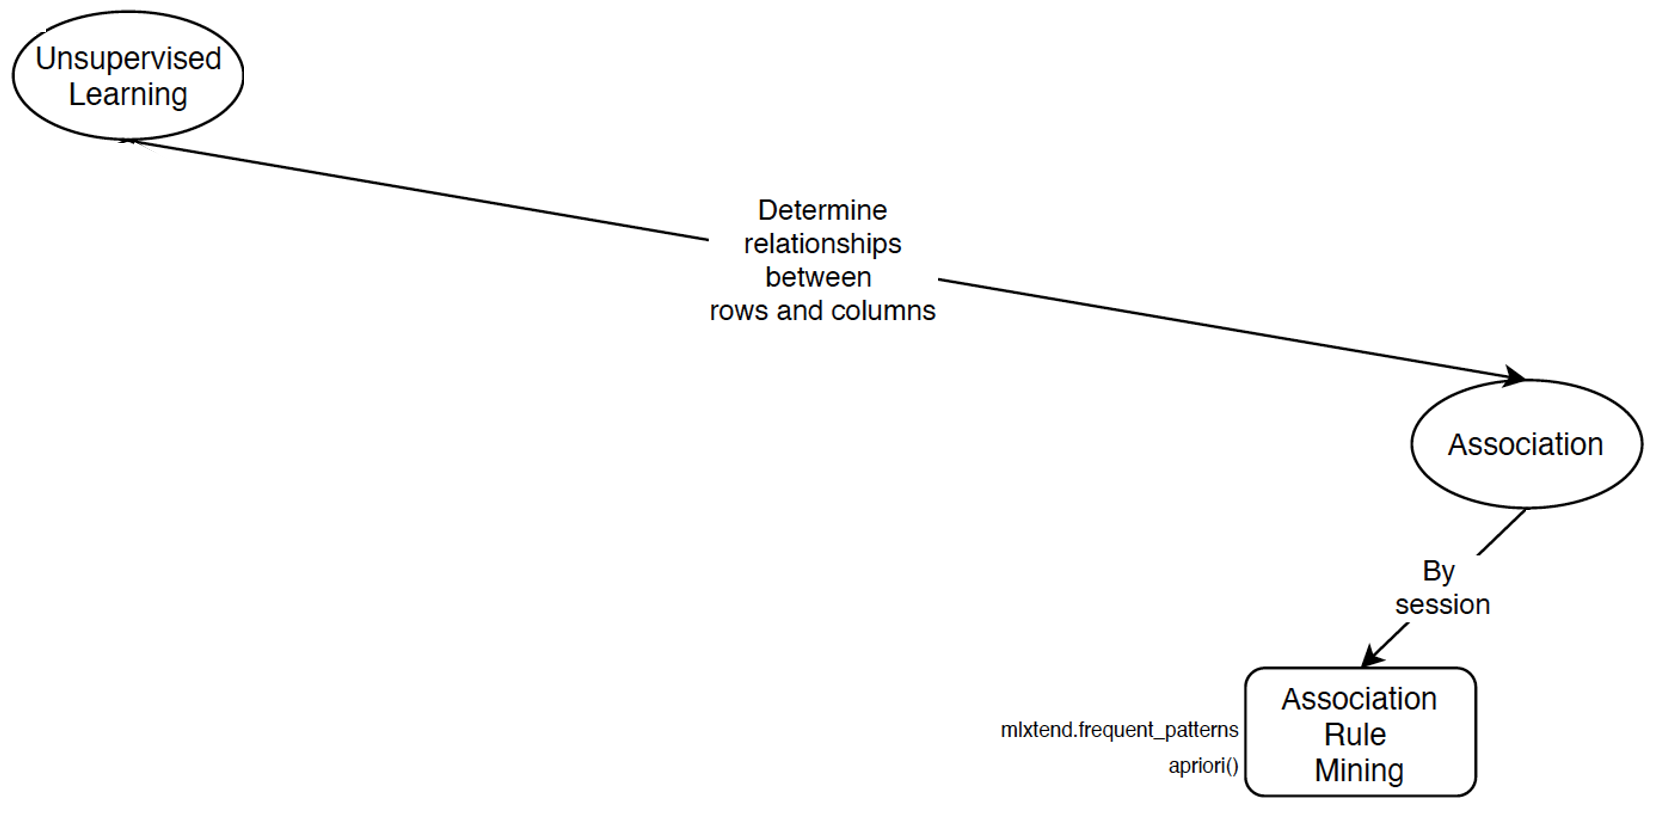

Intro to processing columns i.e. Features:

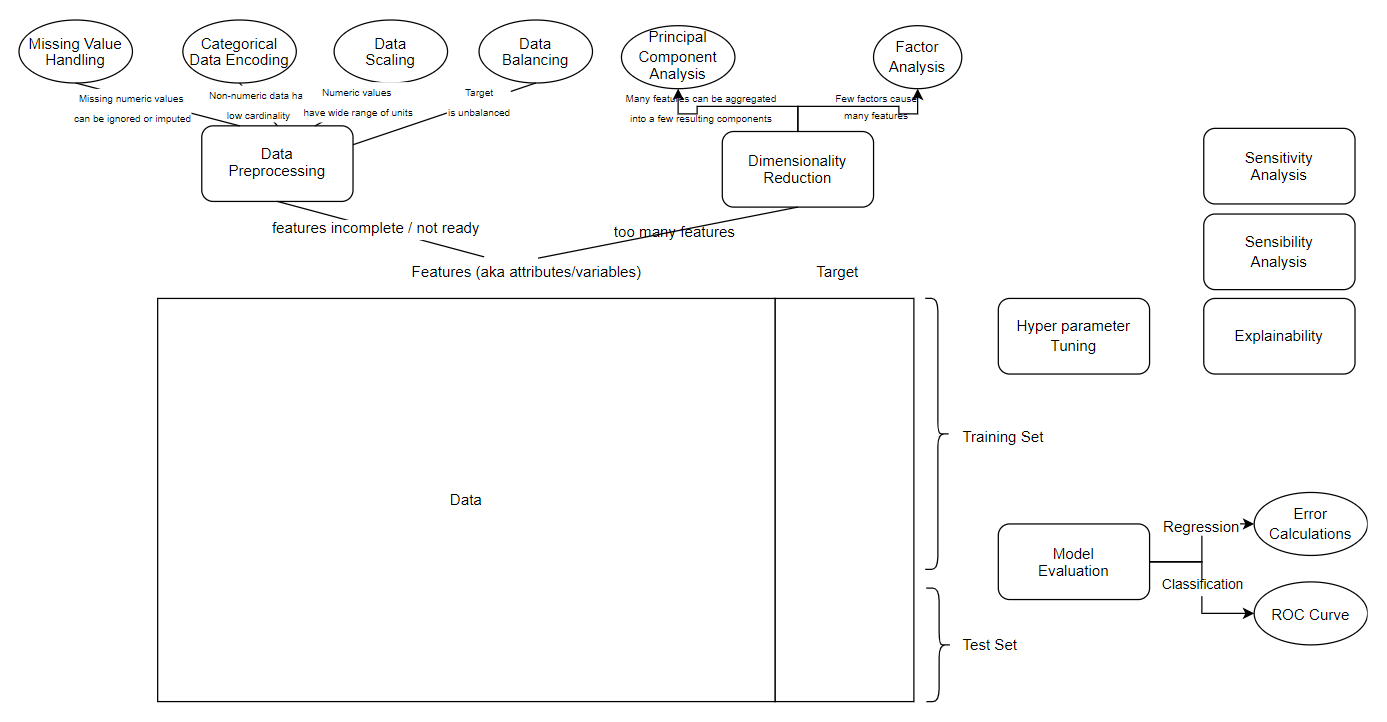

Difference between PCA and Factor Analysis:

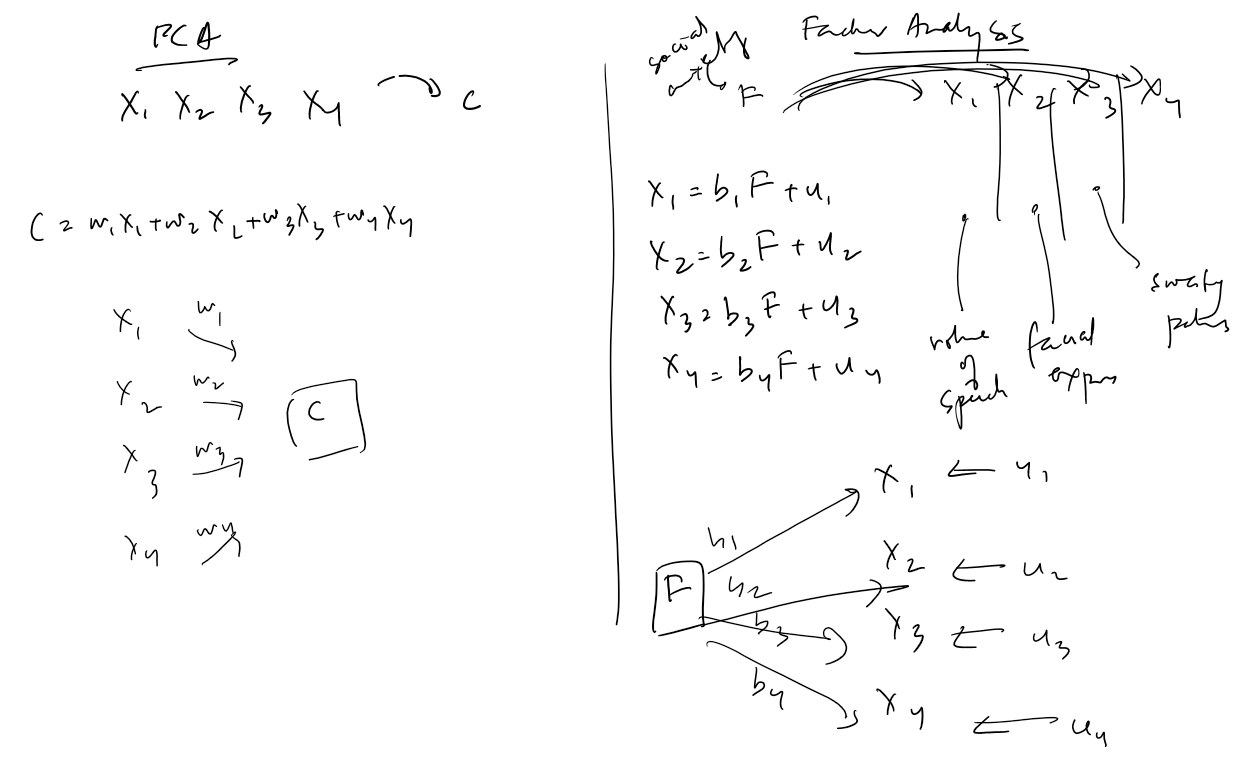

Combining it together in the mindmap:

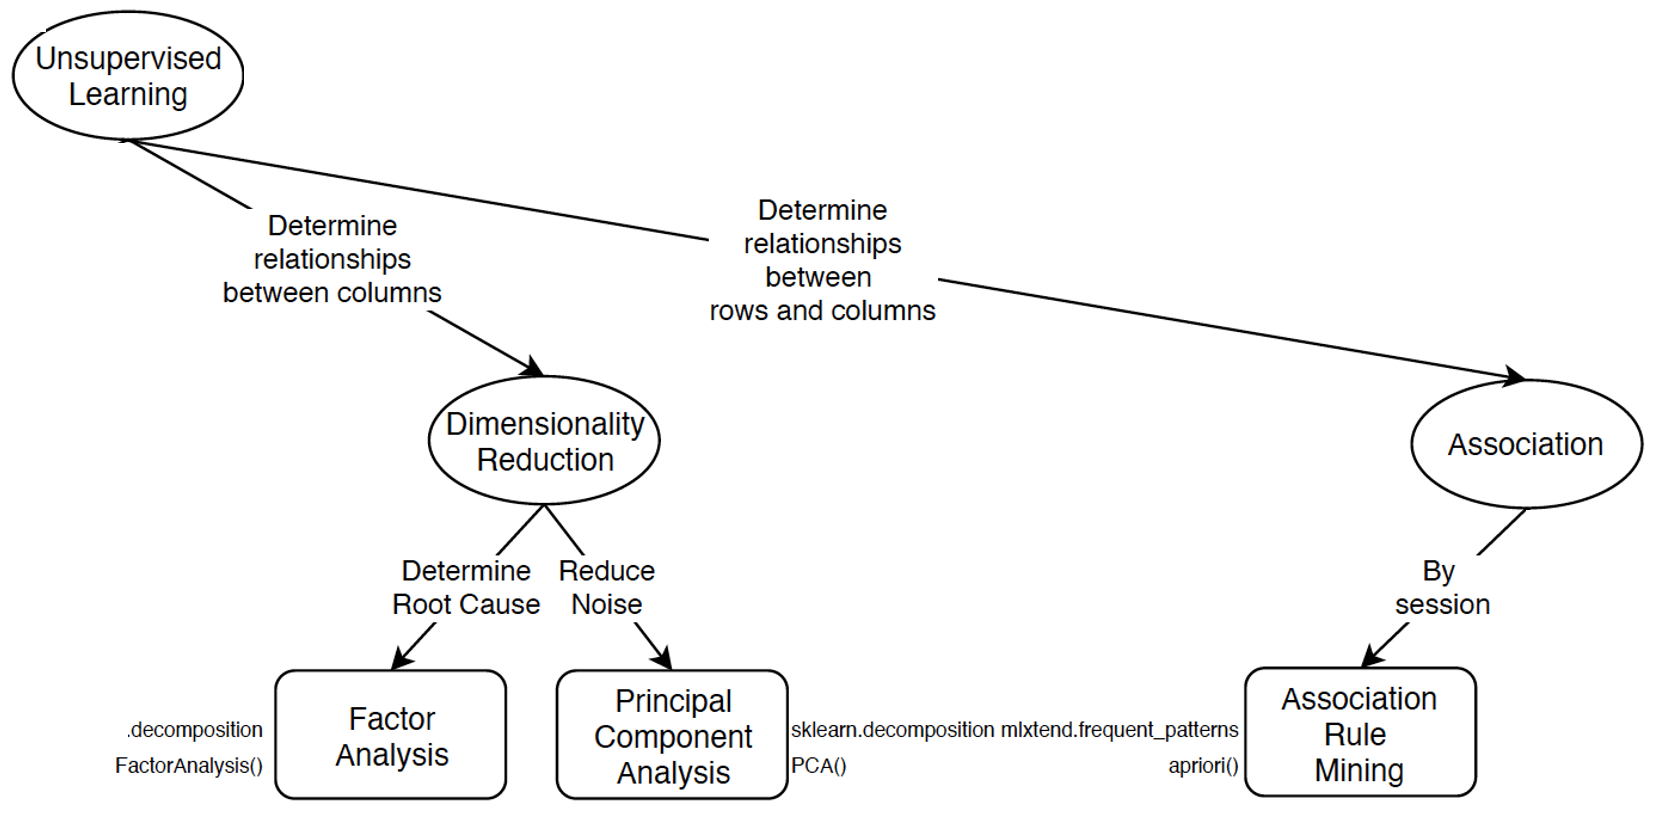

<< WHITEBOARD

utexas_ds_orie_divider_gray.png